In [1]:
import pegasos
import numpy as np
import pickle
from collections import defaultdict

# Keras imports
import keras
from keras.models import load_model, Sequential, Model
from keras.layers import Dropout, Dense, Conv2D, Flatten, MaxPooling2D, Activation, Input, LeakyReLU, BatchNormalization
from keras.callbacks import ModelCheckpoint

class SVM_Triplet:
    def __init__(self, X1, X2, Y, base_classes, pos_class, new_class):
        self.X1 = X1
        self.X2 = X2
        self.Y = Y
        self.base_classes = base_classes
        self.pos_class = pos_class
        self.new_class = new_class

def prepare_features(pos_class, neg_classes, feature_vectors, is_train=True, 
                     equal_features=False, train_split=0.9):
    '''
    Returns 4096-dim features for each image which would be used for SVM training
    inputs : 
        is_train -> will return 90% of features for each class if is_train=True, else returns 10% features
        equal_features -> if set to True, then len(neg_features) = len(pos_features)
    
    Returns:
        pos_features -> features of images in the positive class
        neg_features -> features of images in the negative classes
    '''
    
    if is_train:
        num_pos_samples = int(train_split*feature_vectors[pos_class].shape[0])
        pos_features = feature_vectors[pos_class][:num_pos_samples]    # n x 4096
        
        neg_features = []

        for neg_class in neg_classes:
            num_neg_samples = int(train_split*feature_vectors[neg_class].shape[0])
            neg_features.extend(feature_vectors[neg_class][:num_neg_samples])
            
    else:
        num_pos_samples = int(train_split*feature_vectors[pos_class].shape[0])
        pos_features = feature_vectors[pos_class][num_pos_samples:]    # n x 4096
        
        neg_features = []

        for neg_class in neg_classes:
            num_neg_samples = int(train_split*feature_vectors[neg_class].shape[0])
            neg_features.extend(feature_vectors[neg_class][num_neg_samples:])
             
    if equal_features:
        neg_features = np.random.permutation(neg_features)[:pos_features.shape[0]]
    
    return pos_features, neg_features
    
def compute_accuracy(weight_vector, pos_features, neg_features):
    classifier = pegasos.PegasosSVMClassifier()
    classifier.fit(np.zeros((2, 1024)), np.asarray([1, 0]))
    classifier.weight_vector.weights = weight_vector

    # Concat data and pass to SVM
    result = classifier.predict(np.vstack((pos_features, neg_features)))
    ground_truth = np.concatenate((np.ones(len(pos_features)), np.zeros(len(neg_features))))
    return np.average(np.equal(ground_truth, result))

def get_svm_weights(x_train, y_train):
    svm = pegasos.PegasosSVMClassifier()
    svm.fit(x_train, y_train)
    weight_vector = svm.weight_vector.weights
    return weight_vector


def get_x_y(pos_features, neg_features):
    x = np.vstack((pos_features, neg_features))
    y = np.hstack((np.ones( len(pos_features)),
                   np.zeros(len(neg_features))))
    return x, y

'''
SVM for novel class. 
pos_class = pos_class
neg_classes = base_classes - pos_class
'''
def compute_X1(pos_class, base_classes, feature_vectors, is_train=True):
    neg_classes = np.delete(base_classes, np.argwhere(base_classes==pos_class))
    pos_features, neg_features = prepare_features(pos_class, neg_classes, feature_vectors, is_train=is_train)
    x_train, y_train = get_x_y(pos_features, neg_features)
    weight_vector = get_svm_weights(x_train, y_train)
    return weight_vector

'''
SVM for novel class. 
pos_class = novel_class
neg_classes = base_classes
'''
def compute_X2(novel_class, base_classes, feature_vectors, is_train=True):
    pos_features, neg_features = prepare_features(novel_class, base_classes, feature_vectors, is_train=is_train)
    x_train, y_train = get_x_y(pos_features, neg_features)
    weight_vector = get_svm_weights(x_train, y_train)
    return weight_vector
    
'''
SVM for pos class under the influence of the neg class. 
pos_class = pos_class
neg_classes = base_classes - pos_class + novel_class
'''
def compute_Y(pos_class, novel_class, base_classes, feature_vectors, is_train=True):
    neg_classes = np.delete(base_classes, np.argwhere(base_classes==pos_class))
    neg_classes = np.append(neg_classes, novel_class)
    pos_features, neg_features = prepare_features(pos_class, neg_classes, feature_vectors, is_train=is_train)
    x_train, y_train = get_x_y(pos_features, neg_features)
    weight_vector = get_svm_weights(x_train, y_train)
    return weight_vector

Using TensorFlow backend.


In [2]:
FEATURE_FILE = '/media/red/capstone/data/mit_67/vgg16_features.pickle'
TRIPLETS_FILE = '/media/red/capstone/data/triplets.pkl'

In [3]:
# Load features
# split the classes
# Split the images within each class
import pdb


features, file_names = pickle.load(open(FEATURE_FILE, "rb"))

seed = 1234
np.random.seed(seed)

# Splitting classes into train/val/test
labels = np.array(list(features.keys()))
perm = np.random.permutation(len(labels))
labels = labels[perm]

splits = {}
splits['base']=labels[:30]
splits['novel'] = labels[30:50]
splits['test']=labels[50:]

print(splits)

{'base': array(['meeting_room', 'inside_bus', 'poolinside', 'inside_subway',
       'casino', 'mall', 'subway', 'dining_room', 'toystore', 'classroom',
       'livingroom', 'laundromat', 'greenhouse', 'airport_inside',
       'computerroom', 'fastfood_restaurant', 'bar', 'bathroom', 'museum',
       'children_room', 'concert_hall', 'lobby', 'grocerystore',
       'shoeshop', 'bedroom', 'gameroom', 'auditorium', 'bakery',
       'restaurant_kitchen', 'movietheater'],
      dtype='<U19'), 'novel': array(['trainstation', 'tv_studio', 'gym', 'garage', 'church_inside',
       'bowling', 'corridor', 'operating_room', 'warehouse', 'stairscase',
       'buffet', 'winecellar', 'kindergarden', 'deli', 'dentaloffice',
       'artstudio', 'hairsalon', 'elevator', 'hospitalroom', 'waitingroom'],
      dtype='<U19'), 'test': array(['clothingstore', 'restaurant', 'prisoncell', 'library', 'nursery',
       'jewelleryshop', 'pantry', 'cloister', 'closet', 'videostore',
       'florist', 'studiomusic', 

### Create triplets for training

In [ ]:
import random
from tqdm import tqdm
from time import time

random.seed(1234)
NUM_SIMULATIONS = 100000
triplets = []

for i in tqdm(range(int(NUM_SIMULATIONS/200))):
    base_class_ind = np.random.permutation(len(splits['base']))[:10]
    base_classes = splits['base'][base_class_ind]
    
    X1s = {}
    for pos_class in base_classes:
        X1s[pos_class] = compute_X1(pos_class, base_classes, features)
    
    X2s = {}
    for new_class in splits['novel']:
        X2s[new_class] = compute_X2(new_class, base_classes, features)

    
    # The following code generates 200 triplets - 10 pos classes x 20 novel classes for each pos class
    for pos_class in base_classes:
        X1 = X1s[pos_class]
        for new_class in splits['novel']:
            
            X2 = X2s[new_class]
            Y = compute_Y(pos_class, new_class, base_classes, features)
#             pdb.set_trace()
            
    
    
            # Sanity check
            t1 = time()
#             neg_classes = np.delete(base_classes, np.argwhere(base_classes==pos_class))
#             neg_classes_extra = np.append(neg_classes, new_class)
#             pos_features_test, neg_features_test = prepare_features(pos_class, 
#                                                                     neg_classes_extra, 
#                                                                     features, 
#                                                                     is_train=False, 
#                                                                     equal_features=False)
#             acc1 = compute_accuracy(X1, pos_features_test, neg_features_test)
#             acc2 = compute_accuracy(Y, pos_features_test, neg_features_test)
            print (time() - t1)
            
            print(acc1, acc2)
            
            triplets.append(SVM_Triplet(X1, X2, Y, base_classes, pos_class, new_class))
    
#     # Snapshot after every 200 triplets
#     with open(TRIPLETS_FILE, 'wb') as f:
#         print('Dumping start...')
#         pickle.dump(triplets, f)
    


## Training the regressor network

In [ ]:
# Prepare data for training
triplets = pickle.load(open(TRIPLETS_FILE, "rb"))

In [ ]:
'''
Prepare data for training
'''
normalize = False
X_train, Y_train = [], []
for triplet in triplets:
    
    ### NORMALIZE X1, X2 and Y here!!!
    if normalize:
        X1 = triplet.X1 / np.linalg.norm(triplet.X1, axis=0, keepdims=True)
        X2 = triplet.X2 / np.linalg.norm(triplet.X2, axis=0, keepdims=True)
        Y  = triplet.Y  / np.linalg.norm(triplet.Y,  axis=0, keepdims=True)
        X_train.append(np.hstack((X1, X2)))
        Y_train.append(Y-X1)
    
    else:   
        X_train.append(np.hstack((triplet.X1, triplet.X2)))
        Y_train.append(triplet.Y-triplet.X1)


In [ ]:
'''
Define the architecture
'''
FEATURE_SHAPE = 4096
inp = Input(shape=(FEATURE_SHAPE * 2,))
x = Dense(FEATURE_SHAPE * 2, name='dense_1', activation='relu')(inp)
# x = Dropout(0.1)(x)
# x = BatchNormalization()(x)
x = Dense(FEATURE_SHAPE * 2, name='dense_2', activation='relu')(x)
# x = Dropout(0.1)(x)
# x = BatchNormalization()(x)
x = Dense(FEATURE_SHAPE, name='dense_3', activation='relu')(x)
# x = BatchNormalization()(x)
x = Dense(FEATURE_SHAPE, name='dense_4')(x)

model = Model(inputs=inp, outputs=x)

optimizer = keras.optimizers.Adam(lr=0.0001)

model.compile(loss='cosine_proximity', optimizer=optimizer, metrics=['accuracy'])

    
SAVE_FILE =  'mit_adam_cosine_100k__lr4_nobn_nonorm_{epoch:02d}-{val_acc:.2f}.h5'   
    
checkpoint = ModelCheckpoint(SAVE_FILE, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

model.fit(np.array(X_train), 
          np.array(Y_train), 
          epochs=5, 
          batch_size=32, 
          shuffle=True, 
          verbose=1,
          callbacks=callbacks_list,
          validation_split=0.05)

# model.save('mit_e100_rms_cosine_100k_nobn.h5')

In [ ]:
# Compare our model with the baseline

model = load_model('mit_adam_cosine_100k__lr4_nobn_nonorm_02-0.11.h5')
acc1_all, acc2_all = [], []
per_class_acc = defaultdict(list)

base_class_ind = np.random.permutation(len(splits['base']))[:20]
base_classes = splits['base'][base_class_ind]
  

for pos_class in base_classes:
    acc1, acc2 = [], []
    X1 = compute_X1(pos_class, base_classes, features, is_train=True)
    neg_classes = np.delete(base_classes, np.argwhere(base_classes==pos_class))
    
    for new_class in splits['test']:
        neg_classes_extra = np.append(neg_classes, new_class)    # 9 + 1 classes
        pos_features_test, neg_features_test = prepare_features(pos_class, 
                                                                neg_classes_extra, 
                                                                features, 
                                                                is_train=False, 
                                                                equal_features=False)
        acc1.append(compute_accuracy(X1, pos_features_test, neg_features_test))

        # Test out our incremental hypothesis
        X2 = compute_X2(new_class, base_classes, features, is_train=True)
        X = np.hstack((X1, X2))
        X = np.reshape(X, (1, 8192))
        Y_hat = model.predict(X)
        Y = X1 + Y_hat.reshape((4096))
        acc2.append(compute_accuracy(Y, pos_features_test, neg_features_test))
        print('%.5f %.5f %.5f %s|%s' % (acc1[-1],acc2[-1], acc2[-1] - acc1[-1], pos_class, new_class))
        per_class_acc[pos_class].append(acc2[-1] - acc1[-1])

    acc1_all.append(acc1)
    acc2_all.append(acc2)
    
    
acc1_all = np.array(acc1_all)
acc2_all = np.array(acc2_all)
acc1_mean = np.mean(acc1_all, axis=0)
acc2_mean = np.mean(acc2_all, axis=0)


In [ ]:
# Plotting
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
N = len(splits['test'])         # Number of classes
ind = np.arange(N)                # the x locations for the groups
width = 0.35                      # the width of the bars

## the bars
rects1 = ax.bar(ind, acc1_mean, width,color='orange')
rects2 = ax.bar(ind+width, acc2_mean, width, color='green')

# axes and labels
ax.set_xlim(-width,len(ind)+width)
ax.set_ylim(0,1)
ax.set_ylabel('Accuracy')
ax.set_title('Comparision when adding a new class (10 + 1)')
xTickMarks = ['Class ' + str(i) for i in range(0,21)]
ax.set_xticks(ind+width)
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=45, fontsize=12)

## add a legend
ax.legend( (rects1[0], rects2[0]), ('No update', 'SVM weights updated') )

plt.show()

In [4]:
model = load_model('mit_adam_cosine_100k__lr4_nobn_nonorm_02-0.11.h5')
acc1, acc2 = [], []
per_class_acc = defaultdict(list)

for i in range(200):
    base_class_ind = np.random.permutation(len(splits['base']))[:10]
    base_classes = splits['base'][base_class_ind]
    pos_class = np.random.choice(base_classes)
    
    
    X1 = compute_X1(pos_class, base_classes, features, is_train=True)
    neg_classes = np.delete(base_classes, np.argwhere(base_classes==pos_class))


    new_class = np.random.choice(splits['test'])
    neg_classes_extra = np.append(neg_classes, new_class)    # 9 + 1 classes
    pos_features_test, neg_features_test = prepare_features(pos_class, 
                                                            neg_classes_extra, 
                                                            features, 
                                                            is_train=False, 
                                                            equal_features=False)
    

    # Test out our incremental hypothesis
    X2 = compute_X2(new_class, base_classes, features, is_train=True)

    X1_norm = X1 / np.linalg.norm(X1, axis=0, keepdims=True)
    X2_norm = X2 / np.linalg.norm(X2, axis=0, keepdims=True)

    X = np.hstack((X1_norm, X2_norm))
    X = np.reshape(X, (1, 8192))
    Y_hat = model.predict(X)
    Y = X1 + Y_hat.reshape((4096))
    acc1.append(compute_accuracy(X1, pos_features_test, neg_features_test))
    acc2.append(compute_accuracy(Y, pos_features_test, neg_features_test))
    per_class_acc[pos_class].append(acc2[-1] - acc1[-1])
    print('%.5f %.5f %0.3f %s|%s' % (acc1[-1],acc2[-1], acc2[-1]-acc1[-1], pos_class, new_class)) 

0.90385 0.90385 0.000 shoeshop|prisoncell
0.96866 0.96866 0.000 restaurant_kitchen|bookstore
0.72843 0.72843 0.000 subway|office
0.35294 0.36471 0.012 livingroom|kitchen
0.99673 0.99673 0.000 greenhouse|prisoncell
0.92605 0.92283 -0.003 subway|jewelleryshop
0.78059 0.78059 0.000 livingroom|clothingstore
0.96356 0.96356 0.000 children_room|cloister
0.95489 0.95489 0.000 children_room|laboratorywet
0.71709 0.71709 0.000 livingroom|prisoncell
0.76353 0.76353 0.000 bar|locker_room
1.00000 1.00000 0.000 greenhouse|locker_room
0.93004 0.93004 0.000 auditorium|office
0.96503 0.96503 0.000 grocerystore|locker_room
0.95911 0.95911 0.000 gameroom|cloister
0.96364 0.96000 -0.004 inside_bus|kitchen
0.95987 0.95987 0.000 children_room|kitchen
0.94369 0.94369 0.000 inside_subway|library
0.99320 0.95918 -0.034 children_room|studiomusic
0.94587 0.94587 0.000 auditorium|kitchen
0.96000 0.96000 0.000 concert_hall|jewelleryshop
0.87464 0.87464 0.000 inside_subway|library
0.90667 0.89778 -0.009 dining_roo

0.61004 0.61004 0.000 mall|jewelleryshop
0.92917 0.92917 0.000 movietheater|bookstore
0.88618 0.88618 0.000 dining_room|studiomusic
0.29318 0.32727 0.034 casino|kitchen
0.98408 0.98408 0.000 classroom|prisoncell
0.96835 0.96835 0.000 concert_hall|laboratorywet
0.92162 0.92162 0.000 bedroom|kitchen
0.87636 0.77818 -0.098 bar|closet


shoeshop ----- -0.080402
restaurant_kitchen ----- -0.226761
subway ----- -2.675134
livingroom ----- 0.130719
greenhouse ----- -0.796482
children_room ----- -0.534976
bar ----- -1.368587
auditorium ----- -0.017000
grocerystore ----- 0.603802
gameroom ----- 2.194108
inside_bus ----- 0.089963
inside_subway ----- -1.154053
concert_hall ----- 0.000000
dining_room ----- -0.126984
lobby ----- 2.371274
museum ----- -0.070240
mall ----- -0.049092
meeting_room ----- 2.129697
movietheater ----- -0.175439
toystore ----- -2.448980
laundromat ----- 0.000000
fastfood_restaurant ----- 0.000000
poolinside ----- 0.000000
bakery ----- 9.422492
classroom ----- -0.117583
bedroom ----- 0.555010
casino ----- 0.271601
airport_inside ----- 0.477172
computerroom ----- 0.803859
bathroom ----- 0.265794


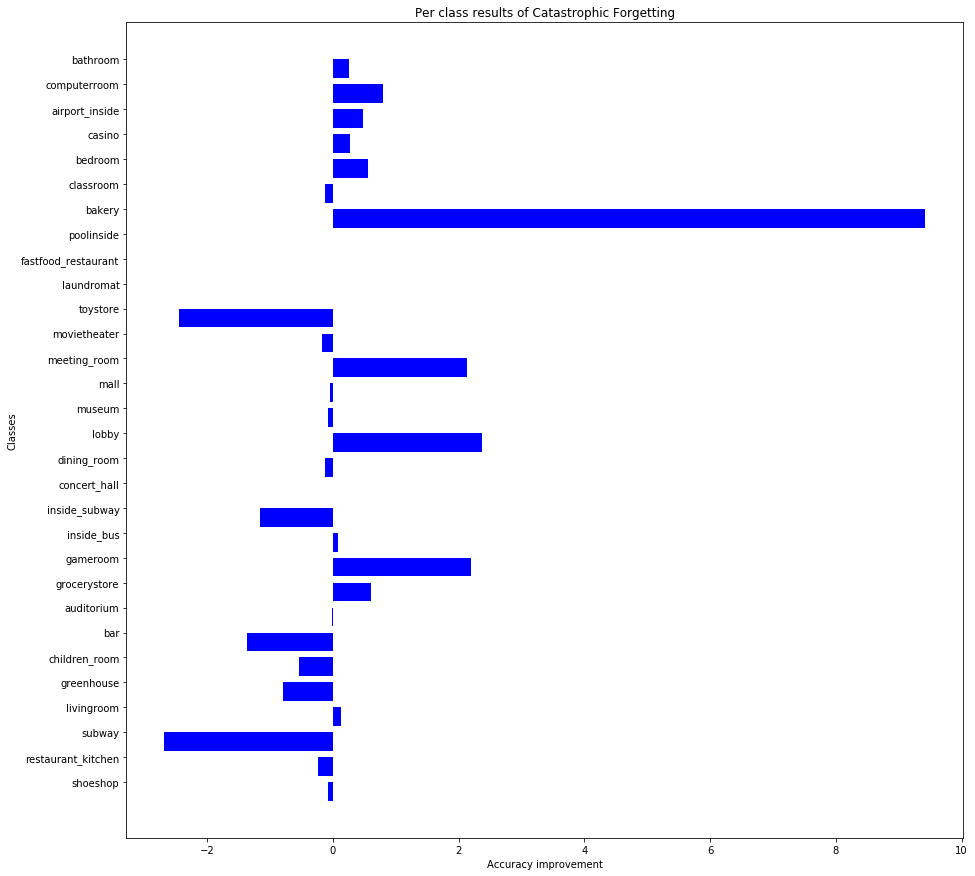

In [18]:
# print(np.mean(acc1))
# print(np.mean(acc2))
# # print(np.mean(acc1_mean))
# # print(np.mean(acc2_mean))
import matplotlib.pyplot as plt
x = []
y = []
for k, v in per_class_acc.items():
    x.append(k)
    y.append(np.mean(v)*100)
    
    print('%s ----- %f'%(x[-1],y[-1]))


    
fig, ax = plt.subplots(figsize=(15, 15))    
width = 0.75 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
ax.barh(ind, y, width, color="blue")
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x, minor=False)
plt.title('Per class results of Catastrophic Forgetting')
plt.xlabel('Accuracy improvement')
plt.ylabel('Classes')    
plt.show()


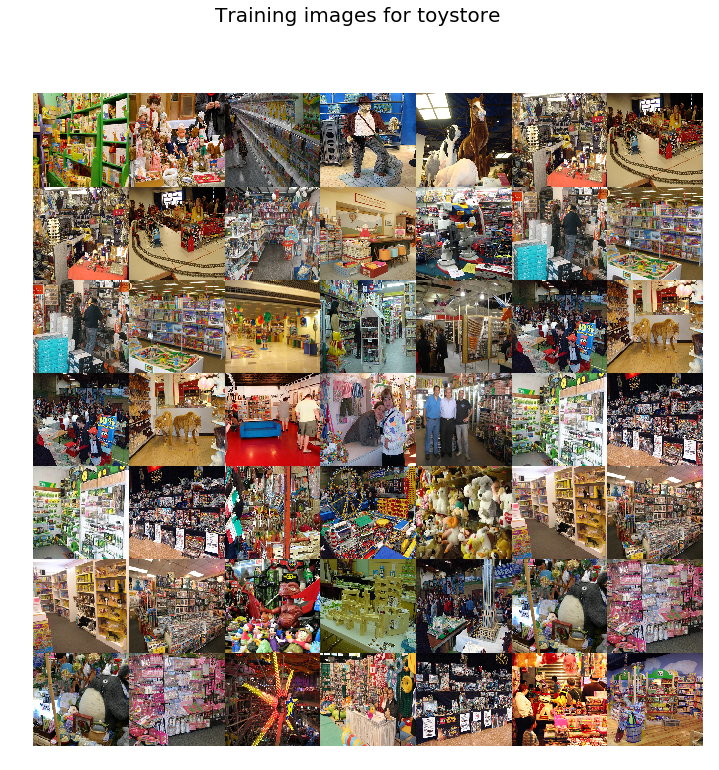

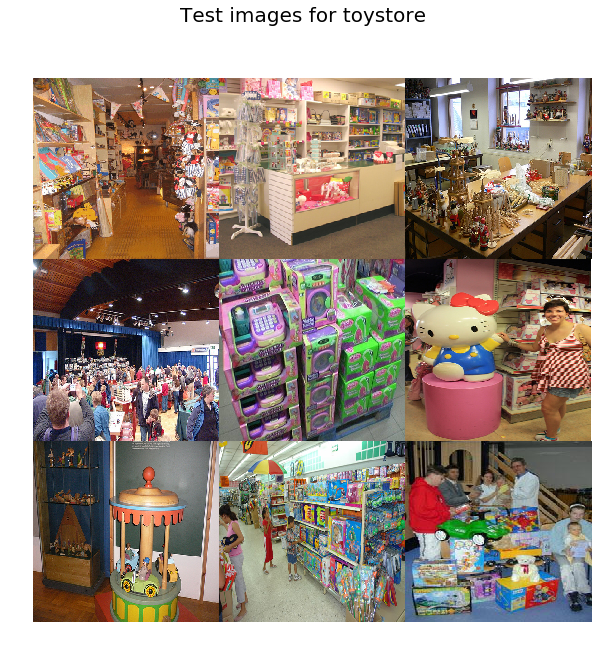

In [15]:
from scipy import misc
import matplotlib.gridspec as gridspec
import os
import matplotlib.pyplot as plt

DATA_PATH = '/media/red/capstone/data/mit_67/Images/'
def preview_category(category):
    # Load data from disk
    features, file_names = pickle.load(open(FEATURE_FILE, "rb"))
    train_split = 0.9
    num_samples = int(train_split*len(file_names[category]))
    training_imgs = file_names[category][:num_samples]
    test_imgs = file_names[category][num_samples:]
    
    # Plot training images 
    num_rows = 7
    num_cols = 7
    fig = plt.figure(figsize=(12,12))
    gs = gridspec.GridSpec(num_rows, num_cols, wspace=0.0, hspace=0.0)
    ax = [plt.subplot(gs[i]) for i in range(num_rows*num_cols)]
    for i in range(num_rows):
        for j in range(num_cols):
            img_path = os.path.join(DATA_PATH, category, training_imgs[5*i+j])
            img = misc.imread(img_path)
            ax[i*num_rows+j].imshow(img)
            ax[i*num_rows+j].axis('off')
            ax[i*num_rows+j].set_aspect('auto')
    fig.suptitle('Training images for %s'%(category), size=20)
    plt.show()
    
    # Plot test images
    num_rows = 3
    num_cols = 3
    fig = plt.figure(figsize=(10,10))
    gs = gridspec.GridSpec(num_rows, num_cols, wspace=0.0, hspace=0.0)
    ax = [plt.subplot(gs[i]) for i in range(num_rows*num_cols)]
    for i in range(num_rows):
        for j in range(num_cols):
            img_path = os.path.join(DATA_PATH, category, test_imgs[5*i+j])
            img = misc.imread(img_path)
            ax[i*num_rows+j].imshow(img)
            ax[i*num_rows+j].axis('off')
            ax[i*num_rows+j].set_aspect('auto')
    fig.suptitle('Test images for %s'%(category), size=20)
    plt.show()
    
preview_category('toystore')
    